## Данные

Датасет Cityscapes - набор изображений городских пейзажей с разметкой отбъектов 30 классов - дорога, здание, человек и т.п. 

Размер изображений - 2048 * 1024.

Хотя датасет имеет 30 классов объектов, оценка качества производится только по 19 из них - в них не входят такие редкие объекты как мосты, парковки и т.п.

In [1]:
import torch
from torchvision.datasets import Cityscapes
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm, trange
import wandb
from typing import Tuple, List
import random
from functools import partial

In [2]:
from cityscapesscripts.helpers.labels import labels

In [3]:
data_dir = "data/"

In [4]:
labels[:2]

[Label(name='unlabeled', id=0, trainId=255, category='void', categoryId=0, hasInstances=False, ignoreInEval=True, color=(0, 0, 0)),
 Label(name='ego vehicle', id=1, trainId=255, category='void', categoryId=0, hasInstances=False, ignoreInEval=True, color=(0, 0, 0))]

## Датасеты и даталоадеры

Этот датасет можно импортировать из torchvision.datasets. Он разбит на train, validation и test. К данным можно применить предобработку с помощью функций transform и target_transform.

In [5]:
# Предобработка данных - аугментация, уменьшение размера, замена меток на 19-классовый вариант разметки
# В Unet и SegFormer данные подаются в разных форматах, поэтому передаем mode в фукцию

def transforms(img: Image, target: Image, 
               mode: str = "unet", image_size: int = 1024) -> Tuple[torch.Tensor, np.array]:
    seed = np.random.randint(100000)
    
    # transform image
    random.seed(seed)
    torch.manual_seed(seed)
    
    img = T.RandomResizedCrop(size=image_size, scale=(0.5, 2))(img)
    if mode == "unet":
        img = T.ToTensor()(img)
    
    # transform target with the same seed
    random.seed(seed)
    torch.manual_seed(seed)
    
    target = T.RandomResizedCrop(size=image_size, scale=(0.5, 2))(target)
    target = np.array(target)
    
    # замена меток на 19-классовый вариант
    for lb in labels:
        target[target == lb.id] = lb.trainId   
    
    if mode == "segformer":
        target = np.expand_dims(target, axis=0)
        
    target = torch.Tensor(target).long()
        
    return img, target


Создадим датасеты для Unet:

In [6]:
unet_transforms = partial(transforms, mode="unet", image_size=256)

In [7]:
train_ds = Cityscapes(data_dir, split="train", mode="fine", target_type="semantic", transforms=unet_transforms)
val_ds = Cityscapes(data_dir, split="val", mode="fine", target_type="semantic", transforms=unet_transforms)
test_ds = Cityscapes(data_dir, split="test", mode="fine", target_type="semantic", transforms=unet_transforms)

Проверим, что получилось:

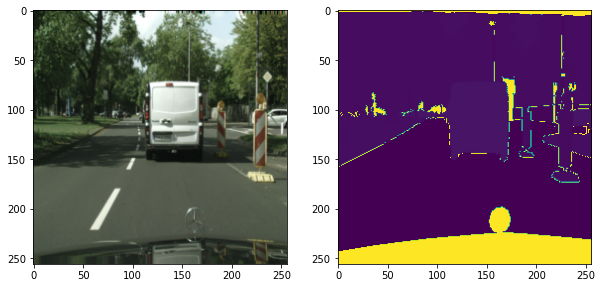

In [8]:
img, smnt = train_ds[0]

fig, axx = plt.subplots(1, 2, figsize=(10, 10))
axx[0].imshow(img.permute(1, 2, 0))
axx[1].imshow(smnt);

Создадим даталоадеры, собирающие примеры из датасетов в батчи:

In [9]:
BATCH_SIZE = 2
train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE)

In [10]:
img.size(), smnt.size()

(torch.Size([3, 256, 256]), torch.Size([256, 256]))

# Evaluation

Для оценки качества моделей будем использовать метрику mean IoU, которая вычисляет среднее IoU по классам. Ее удобно загрузить из библиотеки evaluate.

Метрика не зависит от архитертуры модели, и по ней можно сравнивать модели по качеству.

Попробуем вычислить метрику на игрушечных данных:

In [11]:
import numpy as np
import evaluate
mean_iou = evaluate.load("mean_iou")
predicted = torch.Tensor([[2, 2, 3], [8, 2, 4], [3, 255, 2]]).int().view(3, 3, 1)
ground_truth = torch.Tensor([[1, 2, 2], [8, 2, 1], [3, 255, 1]]).int().view(3, 3, 1)

mean_iou.compute(predictions=predicted, references=ground_truth, num_labels=9, ignore_index=255)

/home/tanya/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union
/home/tanya/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label


{'mean_iou': 0.38,
 'mean_accuracy': 0.6666666666666666,
 'overall_accuracy': 0.5,
 'per_category_iou': array([nan, 0. , 0.4, 0.5, 0. , nan, nan, nan, 1. ]),
 'per_category_accuracy': array([       nan, 0.        , 0.66666667, 1.        ,        nan,
               nan,        nan,        nan, 1.        ])}

## U-net

Архитертура UNet - энкодер - декодер со skip-connections из энкодера в декодер. На выходе модели получаем изображение с разрешением, равным исходному изображению, с числом каналов, равным числу классов объектов. 

Класс с наибольшей вероятностью считается предсказанием модели для данного пискеля. 

Задачу семантической сегментации можно назвать задачей попиксельной классификации. Следовательно, подходящий лосс для такой модели - CrossEntropyLoss.

In [12]:
import pytorch_unet.model_unet
from pytorch_unet.model_unet import UnetGenerator as UNet

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
unet = UNet(in_dim=3, out_dim=19, num_filter=64).to(device)

In [14]:
unet

UnetGenerator(
  (down_1): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_2): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool_2)

In [15]:
wandb.init(project="one_cell")
wandb.watch(unet)

wandb: Currently logged in as: sava_ml (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.14.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[]

In [16]:
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from cityscapesscripts.helpers.labels import trainId2label as t2l

optimizer = Adam(unet.parameters(), lr=4e-3)
ce_loss = torch.nn.CrossEntropyLoss(ignore_index=255)  # 255 - background

mean_iou = evaluate.load("mean_iou")

In [17]:
# trainig loop
# TODO: lr_scheduler

for epoch in trange(3):
    unet.train()
    
    train_losses = []
    
    for x_batch, y_batch in tqdm(train_dataloader, position=0, leave=True):
        unet.train()
        
        y_pred = unet(x_batch.to(device))
        loss = ce_loss(y_pred, y_batch.to(device))
        
        train_losses.append(loss.detach().cpu())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    wandb.log({"train_loss": np.array(train_losses).mean()})
        
    if epoch % 2 == 0:
        unet.eval()
        
        predicted, target = [], []
        val_losses = []
               
        for x_val, y_val in tqdm(val_dataloader, position=0, leave=True):
            y_val_logits = unet(x_val.to(device))
            y_val_pred = torch.argmax(y_val_logits, dim=1)
            val_loss = ce_loss(y_val_logits, y_val.to(device))
            
            val_losses.append(val_loss.detach().cpu())

            predicted.append(y_val_pred.detach().cpu())
            target.append(y_val)

        val_res = mean_iou.compute(predictions=torch.vstack(predicted), 
                                   references=torch.vstack(target), 
                                   num_labels=19, ignore_index=255)
        wandb.log({"val_loss": np.array(val_losses).mean(), "val_meanIoU": val_res['mean_iou']})

100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [1:17:15<00:00, 1545.16s/it]


По логам видно, что обучение началось, лосс падает, метрика качества растет.

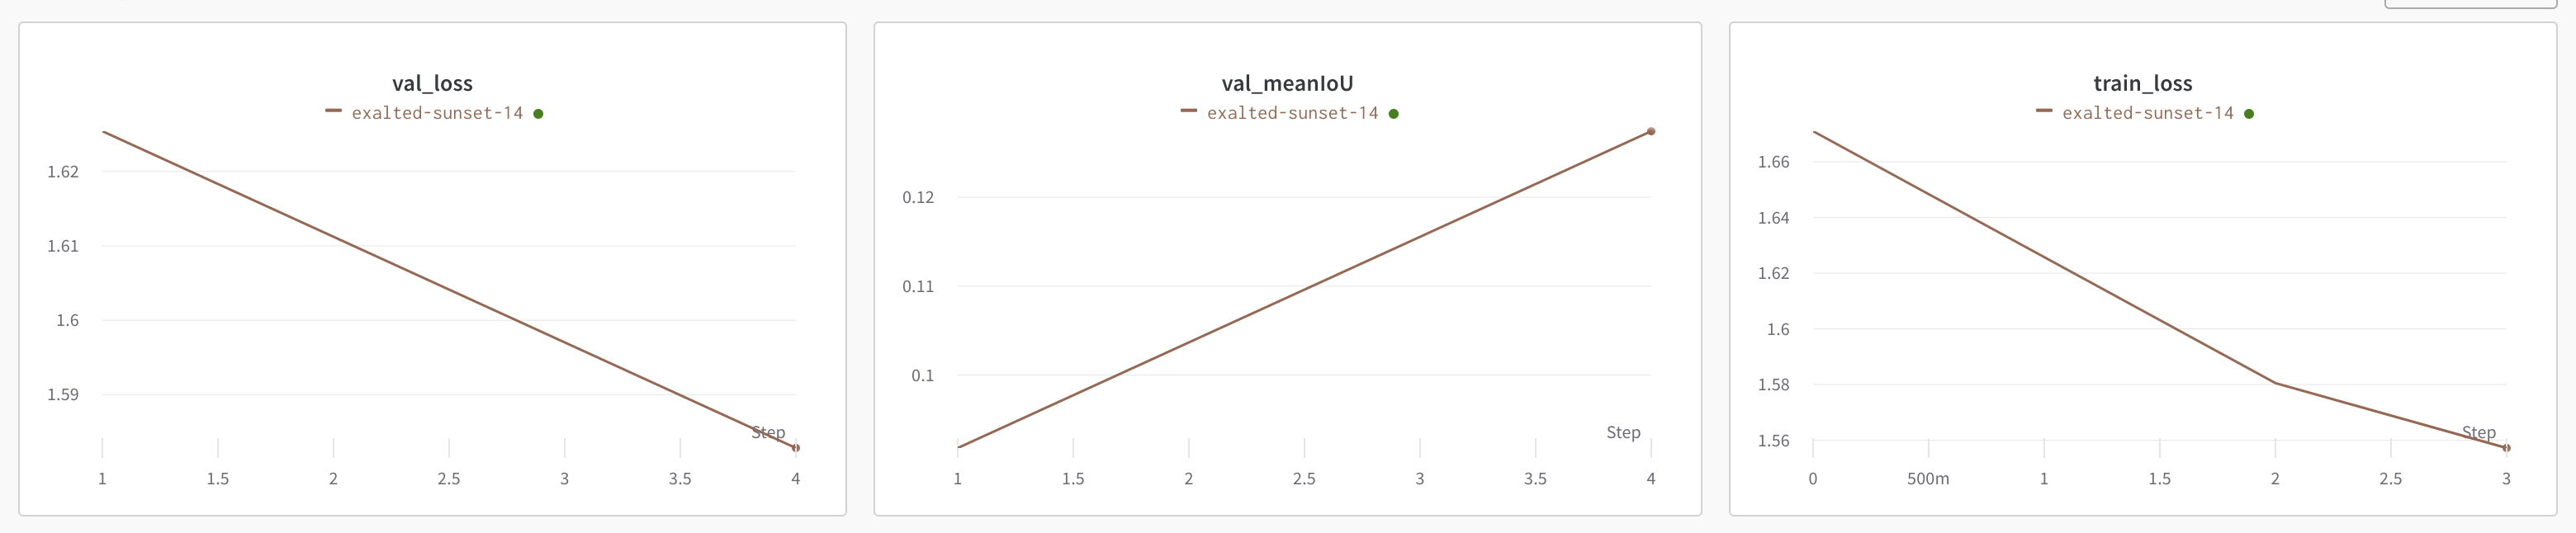

## SegFormer

Архитектура SegFormer построена на архитектуре transformers, имеет иерархический энкодер и легковесный декодер. Лосс, как и в Unet - CrossEntropyLoss.

На huggingface есть предобученные на датасете Cityscapes модели для разных размеров b1, b5. Загрузим более легкую b1:

In [13]:
from transformers import AutoFeatureExtractor, SegformerForSemanticSegmentation

extractor = AutoFeatureExtractor.from_pretrained("nvidia/segformer-b1-finetuned-cityscapes-1024-1024")

segformer = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b1-finetuned-cityscapes-1024-1024")

In [14]:
extractor

SegformerFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "SegformerFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "reduce_labels": false,
  "resample": 2,
  "size": 1024
}

In [15]:
segformer

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

Для оценки качества модели будем использовать ту же метрику meanIoU из библиотеки evaluate:

In [16]:
mean_iou = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    f1_macro = mean_iou.compute(predictions=predictions, references=labels, average='macro')
    return {"mean_iou": f1_macro["mean_iou"], "per_category_iou": f1_micro["per_category_iou"]}

Немного изменим выходы датасета, чтобы подавать примеры в модель:

In [17]:
# Предобработка данных - аугментация, уменьшение размера, замена меток на 19-классовый вариант разметки

sf_transforms = partial(transforms, mode="segformer", image_size=1024)

In [18]:
train_ds = Cityscapes(data_dir, split="train", mode="fine", target_type="semantic", transforms=sf_transforms)
val_ds = Cityscapes(data_dir, split="val", mode="fine", target_type="semantic", transforms=sf_transforms)
test_ds = Cityscapes(data_dir, split="test", mode="fine", target_type="semantic", transforms=sf_transforms)

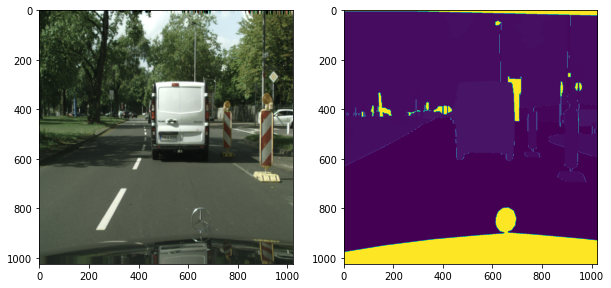

In [19]:
img, smnt = train_ds[0]

fig, axx = plt.subplots(1, 2, figsize=(10, 10))
axx[0].imshow(img)
axx[1].imshow(smnt.permute(1, 2, 0));

Напишем функцию, которая будет формировать батчи примеров в виде словаря:

In [20]:
def data_collator(image_list: List) -> List:
    img_list = [extractor(img, return_tensors="pt")["pixel_values"] for (img, _) in image_list]
    trg_list = [trg for (_, trg) in image_list]
    return {"pixel_values": torch.vstack(img_list), "labels": torch.vstack(trg_list)}

Опишем параметры пайплайнов обучения и валидации (количество эпох обучения, логирование, метрику для выбора лучшей модели, сохранение результатов и т.п.

Укажем данные для обучения и валидации, функцию рассчета метрик:

In [21]:
from transformers import TrainingArguments, Trainer

wandb.init(project="one_cell")

training_args = TrainingArguments(
    output_dir="sf_trainer",
    evaluation_strategy="steps",
    eval_steps=30,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=2,
    save_strategy="steps",
    save_steps=3000,
    save_total_limit=2,
    report_to="wandb",
    load_best_model_at_end=True,
    metric_for_best_model="mean_iou")

trainer = Trainer(
    model=segformer,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics
)

wandb: Currently logged in as: sava_ml (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.14.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Обучение запускалось бы с помощью метода trainer.train(), но ресурсов для него у меня не хватает

In [22]:
# trainer.train()

Оценка качества запускается методом trainer.evaluate(), но для полного прогона также не хватило ресурсов.

In [23]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 500
  Batch size = 2


RuntimeError: CUDA out of memory. Tried to allocate 512.00 MiB (GPU 0; 3.95 GiB total capacity; 1.91 GiB already allocated; 425.50 MiB free; 2.83 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF